<a href="https://colab.research.google.com/github/lmhrva/Thinkful/blob/main/EPA_Compliance_Thinkful_Capstone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EPA Compliance for the State of Virginia

The US Environmental Protection Agency tracks regulates facilities for compliance to environmental sustainability and health standards. They make lots of data available through the site's API. I chose to look at facilities in my home state of Virginia to see how many compliance issues, called Activities in the data, had come up over time in various regions of the state. 

### Purpose
This data can be used by government workers and those interested in environmental regulation to better allocate regulation resources and narrow down any future trends analysis of compliance issues over time and location in Virginia.

### Data
I pulled data from EPA's [ICIS database](https://www.epa.gov/enviro/icis-model).

The Activity Report comes from the [Activity model](https://www.epa.gov/enviro/icis-activity-subject-area-model).

The rest come from the [Facility Interest model](https://www.epa.gov/enviro/icis-facility-interest-subject-area-model).

The following are the datasets I used as my initial dataframes:
1. ICIS_ACTIVITY_RPT_state_code_VA
2. ICIS_FACILITY_INTEREST_state_code_VA

This is the link to the shared Google Drive folder with my datasets:
https://drive.google.com/drive/folders/1Xd1mMksV1EPpoF6j5vkGT_937_T95P4K?usp=sharing



# Run First

In [98]:
import requests
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns 
import matplotlib as plt
sns.set()
from scipy import stats

# Suppress warnings (warnings do not prevent the code from executing)
import warnings
warnings.filterwarnings("ignore")

In [99]:
# with text wrapping
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Importing Data
After pulling the data I needed as csv files, I loaded those into my Google Drive to upload here in Colab.

Here again is the link to the shared folder of data:
https://drive.google.com/drive/folders/1Xd1mMksV1EPpoF6j5vkGT_937_T95P4K?usp=sharing

In [100]:
# get data from the Colab Datasets folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## df1: ICIS_ACTIVITY_RPT_state_code_VA

This shows all activities associated with facilities in Virginia. I've taken out all FY nulls so the only rows available are ones with FY recorded.

In [113]:
# import CSV with corrected column names

csv1 = '/content/gdrive/My Drive/Colab Datasets - Thinkful Capstone 3/ICIS_ACTIVITY_RPT_state_code_VA_cols.csv'
df1 = pd.read_csv(csv1) 
df1.head(10)

,ICIS_FACILITY_INTEREST_ID,ACTIVITY_ID,ACTIVITY_NAME,ACTIVITY_TYPE_CODE,STATE_CODE,COMP_INCENTIVE_DESC,ACTIVITY_TYPE_DESC,STATE_DESC,FISCAL_YEAR,REGION_DESC,ACTUAL_BEGIN_DATE,ACTIVITY_STATUS_DATE,PLANNED_BEGIN_DATE,ACTUAL_END_DATE,PLANNED_END_DATE,CANCELLATION_DATE,ACTIVITY_STATUS_DESC,DURATION,TOTAL_HOURS,MULTIMEDIA_FLAG,CANCELLATION_REASON_DESC,SENSITIVE_DATA_FLAG,INTERNAL_REVIEW_FLAG,COORDINATED_FLAG,CONSOLIDATED_FLAG,EPA_ASSIST_FLAG,PLANNED_BEGIN_DATE_FY,PLANNED_BEGIN_DATE_FYQ,ACTUAL_BEGIN_DATE_FY,ACTUAL_BEGIN_DATE_FYQ,PLANNED_END_DATE_FY,PLANNED_END_DATE_FYQ,ACTUAL_END_DATE_FY,ACTUAL_END_DATE_FYQ,STATE_EPA_FLAG,MOST_RECENT_ADOPT_DATE
0,29520,74296,PRESTON&apos;S SERVICE CORP ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
1,10389,74299,"ENVIRONMENTAL SOLUTIONS, INC ...",CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
2,8117,74221,SIERRA MANUFACTURING COMPANY OF VIRGINIA ...,CMD,VA,NaN,Compliance Determination,Virginia,1992.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
3,18424,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
4,22401,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
5,1185,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
6,35599,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
7,8792,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
8,16916,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
9,7038,74419,"NEXTLINK COMMUNICATIONS, INC., ET. AL. ...",CMD,VA,Telecommunications Incentive Program,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,Y,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN


In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ICIS_FACILITY_INTEREST_ID  100001 non-null  int64  
 1   ACTIVITY_ID                100001 non-null  int64  
 2   ACTIVITY_NAME              99513 non-null   object 
 3   ACTIVITY_TYPE_CODE         100001 non-null  object 
 4   STATE_CODE                 100001 non-null  object 
 5   COMP_INCENTIVE_DESC        1 non-null       object 
 6   ACTIVITY_TYPE_DESC         100001 non-null  object 
 7   STATE_DESC                 100001 non-null  object 
 8   FISCAL_YEAR                21786 non-null   float64
 9   REGION_DESC                100001 non-null  object 
 10  ACTUAL_BEGIN_DATE          1884 non-null    object 
 11  ACTIVITY_STATUS_DATE       23566 non-null   object 
 12  PLANNED_BEGIN_DATE         0 non-null       float64
 13  ACTUAL_END_DATE            96

### take out nulls from FY

In [115]:
# shows nulls in data
df1["FISCAL_YEAR"].notnull()

# shows sum of all not nulls
df1["FISCAL_YEAR"].notnull().sum()

21786

In [116]:
# shows db with dropped nulls from fiscal year
df1[df1["FISCAL_YEAR"].notnull()]

,ICIS_FACILITY_INTEREST_ID,ACTIVITY_ID,ACTIVITY_NAME,ACTIVITY_TYPE_CODE,STATE_CODE,COMP_INCENTIVE_DESC,ACTIVITY_TYPE_DESC,STATE_DESC,FISCAL_YEAR,REGION_DESC,ACTUAL_BEGIN_DATE,ACTIVITY_STATUS_DATE,PLANNED_BEGIN_DATE,ACTUAL_END_DATE,PLANNED_END_DATE,CANCELLATION_DATE,ACTIVITY_STATUS_DESC,DURATION,TOTAL_HOURS,MULTIMEDIA_FLAG,CANCELLATION_REASON_DESC,SENSITIVE_DATA_FLAG,INTERNAL_REVIEW_FLAG,COORDINATED_FLAG,CONSOLIDATED_FLAG,EPA_ASSIST_FLAG,PLANNED_BEGIN_DATE_FY,PLANNED_BEGIN_DATE_FYQ,ACTUAL_BEGIN_DATE_FY,ACTUAL_BEGIN_DATE_FYQ,PLANNED_END_DATE_FY,PLANNED_END_DATE_FYQ,ACTUAL_END_DATE_FY,ACTUAL_END_DATE_FYQ,STATE_EPA_FLAG,MOST_RECENT_ADOPT_DATE
0,29520,74296,PRESTON&apos;S SERVICE CORP ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
1,10389,74299,"ENVIRONMENTAL SOLUTIONS, INC ...",CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
2,8117,74221,SIERRA MANUFACTURING COMPANY OF VIRGINIA ...,CMD,VA,NaN,Compliance Determination,Virginia,1992.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
3,18424,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
4,22401,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000.0,Washington Headquarters,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27315,3400311789,3400439984,UNIVAR 516900003600008,AIF,VA,NaN,Administrative - Informal,Virginia,1995.0,Region 3,NaN,24-Apr-95,NaN,24-Apr-95,24-Apr-95,NaN,Achieved,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995.0,3.0,1995.0,3.0,S,NaN
27316,3400190432,3400439996,BUFFALO AIR HANDLING DIV OF AIR & LIQUID 51009...,AIF,VA,NaN,Administrative - Informal,Virginia,1994.0,Region 3,NaN,5-Oct-93,NaN,5-Oct-93,5-Oct-93,NaN,Achieved,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.0,1.0,1994.0,1.0,S,NaN
27317,3400233793,3400378197,RUBBLE BEE RECYCLING 511794104800010,AFR,VA,NaN,Administrative - Formal,Virginia,2007.0,Region 3,NaN,18-Jan-07,NaN,18-Jan-07,NaN,NaN,Final Order Issued,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0,2.0,S,NaN
27318,3400312258,3400551223,SUN CHEMICAL CORPORATION SHAW LANE 51760003480...,AIF,VA,NaN,Administrative - Informal,Virginia,1991.0,Region 3,NaN,13-Feb-91,NaN,13-Feb-91,13-Feb-91,NaN,Achieved,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991.0,2.0,1991.0,2.0,S,NaN


In [117]:
# shows db with dropped nulls from MOST_RECENT_ADOPT_DATE
df1[df1["MOST_RECENT_ADOPT_DATE"].notnull()]

,ICIS_FACILITY_INTEREST_ID,ACTIVITY_ID,ACTIVITY_NAME,ACTIVITY_TYPE_CODE,STATE_CODE,COMP_INCENTIVE_DESC,ACTIVITY_TYPE_DESC,STATE_DESC,FISCAL_YEAR,REGION_DESC,ACTUAL_BEGIN_DATE,ACTIVITY_STATUS_DATE,PLANNED_BEGIN_DATE,ACTUAL_END_DATE,PLANNED_END_DATE,CANCELLATION_DATE,ACTIVITY_STATUS_DESC,DURATION,TOTAL_HOURS,MULTIMEDIA_FLAG,CANCELLATION_REASON_DESC,SENSITIVE_DATA_FLAG,INTERNAL_REVIEW_FLAG,COORDINATED_FLAG,CONSOLIDATED_FLAG,EPA_ASSIST_FLAG,PLANNED_BEGIN_DATE_FY,PLANNED_BEGIN_DATE_FYQ,ACTUAL_BEGIN_DATE_FY,ACTUAL_BEGIN_DATE_FYQ,PLANNED_END_DATE_FY,PLANNED_END_DATE_FYQ,ACTUAL_END_DATE_FY,ACTUAL_END_DATE_FYQ,STATE_EPA_FLAG,MOST_RECENT_ADOPT_DATE
2509,3329830,3200543306,TOWN OF BROADWAY REGIONAL WWTF (Permit VA00902...,INS,VA,NaN,Inspection/Evaluation,Virginia,2010.0,Region 3,NaN,16-Mar-10,NaN,16-Mar-10,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,2.0,S,16-Mar-10
2524,3200007262,3200559191,SOUTH CENTRAL WASTEWATER AUTHO (Permit VA00254...,INS,VA,NaN,Inspection/Evaluation,Virginia,1997.0,Region 3,NaN,5-Mar-97,NaN,5-Mar-97,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1997.0,2.0,S,5-Mar-97
2535,3200007262,3200559228,SOUTH CENTRAL WASTEWATER AUTHO (Permit VA00254...,INS,VA,NaN,Inspection/Evaluation,Virginia,2005.0,Region 3,NaN,17-May-05,NaN,17-May-05,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2005.0,3.0,S,17-May-05
2607,3200033296,3200548638,NOMAN M COLE JR POLLUTION CONT (Permit VA00253...,INS,VA,NaN,Inspection/Evaluation,Virginia,1999.0,Region 3,NaN,23-Mar-99,NaN,23-Mar-99,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1999.0,2.0,S,23-Mar-99
2612,3200010802,3200558979,PEPPERS FERRY REGIONAL WASTEWA (Permit VA00626...,INS,VA,NaN,Inspection/Evaluation,Virginia,2005.0,Region 3,NaN,2-Nov-04,NaN,2-Nov-04,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2005.0,1.0,S,2-Nov-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22284,600036083,3200549927,HOPEWELL WWTP (Permit VA0066630) Pretreatment ...,INS,VA,NaN,Inspection/Evaluation,Virginia,1997.0,Region 3,NaN,11-Jun-97,NaN,11-Jun-97,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1997.0,3.0,S,11-Jun-97
22287,600036083,3200549946,HOPEWELL WWTP (Permit VA0066630) Pretreatment ...,INS,VA,NaN,Inspection/Evaluation,Virginia,2001.0,Region 3,NaN,18-Jul-01,NaN,18-Jul-01,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2001.0,4.0,S,18-Jul-01
22359,3330078,3200554785,HRSD - ATLANTIC SEWAGE TREATME (Permit VA00812...,INS,VA,NaN,Inspection/Evaluation,Virginia,2007.0,Region 3,NaN,26-Feb-07,NaN,26-Feb-07,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,2007.0,2.0,S,26-Feb-07
22361,3330078,3200554806,HRSD - ATLANTIC SEWAGE TREATME (Permit VA00812...,INS,VA,NaN,Inspection/Evaluation,Virginia,1991.0,Region 3,NaN,16-May-91,NaN,16-May-91,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1991.0,3.0,S,16-May-91


In [118]:
# drop rows from specific columns if na
df1.dropna(subset=['FISCAL_YEAR'], inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21786 entries, 0 to 27319
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID  21786 non-null  int64  
 1   ACTIVITY_ID                21786 non-null  int64  
 2   ACTIVITY_NAME              21786 non-null  object 
 3   ACTIVITY_TYPE_CODE         21786 non-null  object 
 4   STATE_CODE                 21786 non-null  object 
 5   COMP_INCENTIVE_DESC        1 non-null      object 
 6   ACTIVITY_TYPE_DESC         21786 non-null  object 
 7   STATE_DESC                 21786 non-null  object 
 8   FISCAL_YEAR                21786 non-null  float64
 9   REGION_DESC                21786 non-null  object 
 10  ACTUAL_BEGIN_DATE          1053 non-null   object 
 11  ACTIVITY_STATUS_DATE       21642 non-null  object 
 12  PLANNED_BEGIN_DATE         0 non-null      float64
 13  ACTUAL_END_DATE            21422 non-null  obj

In [119]:
# drop rows where all elements are missing
df1.dropna(how='all', inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21786 entries, 0 to 27319
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID  21786 non-null  int64  
 1   ACTIVITY_ID                21786 non-null  int64  
 2   ACTIVITY_NAME              21786 non-null  object 
 3   ACTIVITY_TYPE_CODE         21786 non-null  object 
 4   STATE_CODE                 21786 non-null  object 
 5   COMP_INCENTIVE_DESC        1 non-null      object 
 6   ACTIVITY_TYPE_DESC         21786 non-null  object 
 7   STATE_DESC                 21786 non-null  object 
 8   FISCAL_YEAR                21786 non-null  float64
 9   REGION_DESC                21786 non-null  object 
 10  ACTUAL_BEGIN_DATE          1053 non-null   object 
 11  ACTIVITY_STATUS_DATE       21642 non-null  object 
 12  PLANNED_BEGIN_DATE         0 non-null      float64
 13  ACTUAL_END_DATE            21422 non-null  obj

### fix float types to numeric

In [120]:
# convert column "FISCAL_YEAR" to numeric
# since 'datetime' gave me a weird coded full date and timestamp, not just a FY

# df1['FISCAL_YEAR'].astype(int)
# pd.to_numeric(df1['FISCAL_YEAR'])
df1 = df1.astype({'FISCAL_YEAR': np.int64})

print(df1.dtypes)

ICIS_FACILITY_INTEREST_ID      int64
ACTIVITY_ID                    int64
ACTIVITY_NAME                 object
ACTIVITY_TYPE_CODE            object
STATE_CODE                    object
COMP_INCENTIVE_DESC           object
ACTIVITY_TYPE_DESC            object
STATE_DESC                    object
FISCAL_YEAR                    int64
REGION_DESC                   object
ACTUAL_BEGIN_DATE             object
ACTIVITY_STATUS_DATE          object
PLANNED_BEGIN_DATE           float64
ACTUAL_END_DATE               object
PLANNED_END_DATE              object
CANCELLATION_DATE            float64
ACTIVITY_STATUS_DESC          object
DURATION                     float64
TOTAL_HOURS                  float64
MULTIMEDIA_FLAG               object
CANCELLATION_REASON_DESC     float64
SENSITIVE_DATA_FLAG           object
INTERNAL_REVIEW_FLAG          object
COORDINATED_FLAG             float64
CONSOLIDATED_FLAG            float64
EPA_ASSIST_FLAG               object
PLANNED_BEGIN_DATE_FY        float64
P

In [121]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21786 entries, 0 to 27319
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID  21786 non-null  int64  
 1   ACTIVITY_ID                21786 non-null  int64  
 2   ACTIVITY_NAME              21786 non-null  object 
 3   ACTIVITY_TYPE_CODE         21786 non-null  object 
 4   STATE_CODE                 21786 non-null  object 
 5   COMP_INCENTIVE_DESC        1 non-null      object 
 6   ACTIVITY_TYPE_DESC         21786 non-null  object 
 7   STATE_DESC                 21786 non-null  object 
 8   FISCAL_YEAR                21786 non-null  int64  
 9   REGION_DESC                21786 non-null  object 
 10  ACTUAL_BEGIN_DATE          1053 non-null   object 
 11  ACTIVITY_STATUS_DATE       21642 non-null  object 
 12  PLANNED_BEGIN_DATE         0 non-null      float64
 13  ACTUAL_END_DATE            21422 non-null  obj

In [122]:
# convert all dates to datetime

df1 = df1.astype({'FISCAL_YEAR': np.int64})
df1 = df1.astype({'ACTUAL_BEGIN_DATE':np.datetime64})
df1 = df1.astype({'ACTIVITY_STATUS_DATE':np.datetime64})
df1 = df1.astype({'ACTUAL_END_DATE':np.datetime64})
df1 = df1.astype({'PLANNED_END_DATE':np.datetime64})
df1 = df1.astype({'MOST_RECENT_ADOPT_DATE': np.datetime64})
df1.ACTUAL_BEGIN_DATE_FY = df1.ACTUAL_BEGIN_DATE_FY.astype('Int64')
df1.ACTUAL_BEGIN_DATE_FYQ = df1.ACTUAL_BEGIN_DATE_FYQ.astype('Int64')
df1.PLANNED_END_DATE_FY = df1.PLANNED_END_DATE_FY.astype('Int64')
df1.PLANNED_END_DATE_FYQ = df1.PLANNED_END_DATE_FYQ.astype('Int64')
df1.ACTUAL_END_DATE_FY = df1.ACTUAL_END_DATE_FY.astype('Int64')
df1.ACTUAL_END_DATE_FYQ = df1.ACTUAL_END_DATE_FYQ.astype('Int64')

df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21786 entries, 0 to 27319
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID  21786 non-null  int64         
 1   ACTIVITY_ID                21786 non-null  int64         
 2   ACTIVITY_NAME              21786 non-null  object        
 3   ACTIVITY_TYPE_CODE         21786 non-null  object        
 4   STATE_CODE                 21786 non-null  object        
 5   COMP_INCENTIVE_DESC        1 non-null      object        
 6   ACTIVITY_TYPE_DESC         21786 non-null  object        
 7   STATE_DESC                 21786 non-null  object        
 8   FISCAL_YEAR                21786 non-null  int64         
 9   REGION_DESC                21786 non-null  object        
 10  ACTUAL_BEGIN_DATE          1053 non-null   datetime64[ns]
 11  ACTIVITY_STATUS_DATE       21642 non-null  datetime64[ns]
 12  PLAN

In [123]:
df1.head()

,ICIS_FACILITY_INTEREST_ID,ACTIVITY_ID,ACTIVITY_NAME,ACTIVITY_TYPE_CODE,STATE_CODE,COMP_INCENTIVE_DESC,ACTIVITY_TYPE_DESC,STATE_DESC,FISCAL_YEAR,REGION_DESC,ACTUAL_BEGIN_DATE,ACTIVITY_STATUS_DATE,PLANNED_BEGIN_DATE,ACTUAL_END_DATE,PLANNED_END_DATE,CANCELLATION_DATE,ACTIVITY_STATUS_DESC,DURATION,TOTAL_HOURS,MULTIMEDIA_FLAG,CANCELLATION_REASON_DESC,SENSITIVE_DATA_FLAG,INTERNAL_REVIEW_FLAG,COORDINATED_FLAG,CONSOLIDATED_FLAG,EPA_ASSIST_FLAG,PLANNED_BEGIN_DATE_FY,PLANNED_BEGIN_DATE_FYQ,ACTUAL_BEGIN_DATE_FY,ACTUAL_BEGIN_DATE_FYQ,PLANNED_END_DATE_FY,PLANNED_END_DATE_FYQ,ACTUAL_END_DATE_FY,ACTUAL_END_DATE_FYQ,STATE_EPA_FLAG,MOST_RECENT_ADOPT_DATE
0,29520,74296,PRESTON&apos;S SERVICE CORP ...,CMD,VA,NaN,Compliance Determination,Virginia,2000,Washington Headquarters,NaT,NaT,NaN,NaT,NaT,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,E,NaT
1,10389,74299,"ENVIRONMENTAL SOLUTIONS, INC ...",CMD,VA,NaN,Compliance Determination,Virginia,2000,Washington Headquarters,NaT,NaT,NaN,NaT,NaT,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,E,NaT
2,8117,74221,SIERRA MANUFACTURING COMPANY OF VIRGINIA ...,CMD,VA,NaN,Compliance Determination,Virginia,1992,Washington Headquarters,NaT,NaT,NaN,NaT,NaT,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,E,NaT
3,18424,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000,Washington Headquarters,NaT,NaT,NaN,NaT,NaT,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,E,NaT
4,22401,74348,MOBIL OIL ...,CMD,VA,NaN,Compliance Determination,Virginia,2000,Washington Headquarters,NaT,NaT,NaN,NaT,NaT,NaN,Active,NaN,NaN,N,NaN,N,N,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,E,NaT


### drop all-null columns



In [124]:
# drop the columns that are all nulls

df1.drop(['COMP_INCENTIVE_DESC'], axis=1, inplace=True)
df1.drop(['PLANNED_BEGIN_DATE'], axis=1, inplace=True)
df1.drop(['CANCELLATION_DATE'], axis=1, inplace=True)
df1.drop(['DURATION'], axis=1, inplace=True)
df1.drop(['TOTAL_HOURS'], axis=1, inplace=True)
df1.drop(['CANCELLATION_REASON_DESC'], axis=1, inplace=True)
df1.drop(['COORDINATED_FLAG'], axis=1, inplace=True)
df1.drop(['CONSOLIDATED_FLAG'], axis=1, inplace=True)
df1.drop(['PLANNED_BEGIN_DATE_FY'], axis=1, inplace=True)
df1.drop(['PLANNED_BEGIN_DATE_FYQ'], axis=1, inplace=True)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21786 entries, 0 to 27319
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID  21786 non-null  int64         
 1   ACTIVITY_ID                21786 non-null  int64         
 2   ACTIVITY_NAME              21786 non-null  object        
 3   ACTIVITY_TYPE_CODE         21786 non-null  object        
 4   STATE_CODE                 21786 non-null  object        
 5   ACTIVITY_TYPE_DESC         21786 non-null  object        
 6   STATE_DESC                 21786 non-null  object        
 7   FISCAL_YEAR                21786 non-null  int64         
 8   REGION_DESC                21786 non-null  object        
 9   ACTUAL_BEGIN_DATE          1053 non-null   datetime64[ns]
 10  ACTIVITY_STATUS_DATE       21642 non-null  datetime64[ns]
 11  ACTUAL_END_DATE            21422 non-null  datetime64[ns]
 12  PLAN

In [125]:
df1.FISCAL_YEAR.unique()

array([2000, 1992, 1990, 1997, 2001, 1993, 1994, 1989, 1991, 1996, 2002,
       1999, 1983, 1998,    0, 2009, 2010, 1995, 2006, 2005, 2008, 2004,
       2012, 1987, 1984, 2011, 2007, 1986, 1988, 2003, 1985, 2013, 1982,
       1981, 2014, 2015])

In [126]:
# number of unique values by column

n1 = df1.FISCAL_YEAR.nunique(dropna= True)
print("Number of unique FYs is", n1)

Number of unique FYs is 36


## df2: ICIS_FACILITY_INTEREST_state_code_VA

This dataset shows all the information about Facilities in Virginia. I'll join it to the Activity Report to get a separate set with just the facilities with activities in df1.

In [127]:
csv2 = '/content/gdrive/My Drive/Colab Datasets - Thinkful Capstone 3/ICIS_FACILITY_INTEREST_state_code_VA_cols.csv'
df2 = pd.read_csv(csv2) 
df2.head(5)

,ICIS_FACILITY_INTEREST_ID,PGM_SYS_ACRNM,PGM_SYS_ID,FACILITY_UIN,FACILITY_TYPE_DESC,FACILITY_NAME,LOCATION_ADDRESS,SUPPLEMENTAL_ADDRESS_TEXT,CITY,CITY_NAME,COUNTY_NAME,STATE_CODE,STATE_DESC,ZIP,COUNTRY_DESC,FEDERAL_FACILITY_ID,FEDERAL_FACILITY_FLAG,TRIBAL_LAND_FLAG,CONGRESSIONAL_DIST_NUM,LEGISLATIVE_DIST_NUM,FEDERAL_AGENCY_NAME,HUC_CODE,REGION_DESC,TRIBAL_LAND_R_CODE,ORGANIZATION_DUNS_NMBR,SMALL_BUSINESS_FLAG,ENVIRONMENTAL_JUSTICE_DESC,COMMENT_TEXT,STATE_REGION,NPL_FLAG,SENSITIVE_DATA_FLAG,STATE_FACILITY_ID,SECTION_TOWNSHIP_RANGE,UDF1,UDF2,UDF3,UDF4,UDF5,GEOCODE_LONGITUDE,GEOCODE_LATITUDE,CONSTRUCTION_PROJECT_NAME,GEOMETRIC_TYPE_NAME,HORIZONTAL_COLLECT_METHOD_TEXT,HORIZONTAL_REF_DATUM_NAME,REFERENCE_POINT_CODE,REFERENCE_POINT_DESC,CONSTRUCTION_PROJECT_LAT,CONSTRUCTION_PROJECT_LONG,HORIZONTAL_ACCURACY_MEASURE,SOURCE_MAP_SCALE_NMBR,AIR_LCON_CODE,ORIG_GEOCODE_COORD_FORMAT_CODE,ORIG_CONSTR_COORD_FORMAT_CODE,FACILITY_TYPE_CODE
0,41619,ICIS,41619,1.100110e+11,NaN,ALLEGHENY SPRINGS WATER WORKS,RT 1,NaN,SHAWSVILLE,Shawsville,Montgomery,VA,Virginia,24162,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Region 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80.213930,37.097335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DD,DD,NaN
1,41628,ICIS,41628,1.100110e+11,NaN,RANDLE RIDGE,RT 1 2734 N MARY MAC RD,NaN,CULPEPER,Culpeper,Culpeper,VA,Virginia,22701,NaN,NaN,N,NaN,2.0,NaN,NaN,NaN,Region 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DD,DD,NaN
2,41629,ICIS,41629,1.100110e+11,NaN,PORTER FARM SUBDIVISION WATER ASSOCIATION,RTES 644 & 1001,NaN,BLUEFIELD,Bluefield,Tazewell,VA,Virginia,24605,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,Region 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.448700,37.244800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,NaN,NaN,DD,DD,NaN
3,42734,ICIS,42734,1.100090e+11,NaN,DIXIE CAVERNS COUNTY LANDFILL,RTE 778,RTE 778,SALEM,NaN,Roanoke,VA,Virginia,24153,NaN,NaN,N,NaN,9.0,NaN,NaN,NaN,Region 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80.193610,37.259710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,DD,DD,NaN
4,42102,ICIS,42102,1.100120e+11,NaN,TAZEWELL HAPPY MARK,RT 460 E,NaN,TAZEWELL,Tazewell,Tazewell,VA,Virginia,24651,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,Region 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.532369,37.112778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DD,DD,NaN


In [128]:
df2.shape

(20387, 54)

In [129]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20387 entries, 0 to 20386
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID       20387 non-null  int64  
 1   PGM_SYS_ACRNM                   20387 non-null  object 
 2   PGM_SYS_ID                      20387 non-null  object 
 3   FACILITY_UIN                    19660 non-null  float64
 4   FACILITY_TYPE_DESC              14893 non-null  object 
 5   FACILITY_NAME                   20387 non-null  object 
 6   LOCATION_ADDRESS                20375 non-null  object 
 7   SUPPLEMENTAL_ADDRESS_TEXT       258 non-null    object 
 8   CITY                            20378 non-null  object 
 9   CITY_NAME                       3838 non-null   object 
 10  COUNTY_NAME                     14041 non-null  object 
 11  STATE_CODE                      20387 non-null  object 
 12  STATE_DESC                      

### fix float types to numeric

In [130]:
# change certain floats to ints

df2.CONGRESSIONAL_DIST_NUM = df2.CONGRESSIONAL_DIST_NUM.astype('Int64')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20387 entries, 0 to 20386
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID       20387 non-null  int64  
 1   PGM_SYS_ACRNM                   20387 non-null  object 
 2   PGM_SYS_ID                      20387 non-null  object 
 3   FACILITY_UIN                    19660 non-null  float64
 4   FACILITY_TYPE_DESC              14893 non-null  object 
 5   FACILITY_NAME                   20387 non-null  object 
 6   LOCATION_ADDRESS                20375 non-null  object 
 7   SUPPLEMENTAL_ADDRESS_TEXT       258 non-null    object 
 8   CITY                            20378 non-null  object 
 9   CITY_NAME                       3838 non-null   object 
 10  COUNTY_NAME                     14041 non-null  object 
 11  STATE_CODE                      20387 non-null  object 
 12  STATE_DESC                      

### drop all-null and unneccesary columns

In [131]:
# drop the columns I don't need

df2.drop(['LOCATION_ADDRESS'], axis=1, inplace=True)
df2.drop(['SUPPLEMENTAL_ADDRESS_TEXT'], axis=1, inplace=True)
df2.drop(['TRIBAL_LAND_R_CODE'], axis=1, inplace=True)
df2.drop(['COMMENT_TEXT'], axis=1, inplace=True)
df2.drop(['NPL_FLAG'], axis=1, inplace=True)
df2.drop(['SECTION_TOWNSHIP_RANGE'], axis=1, inplace=True)
df2.drop(['UDF1'], axis=1, inplace=True)
df2.drop(['UDF2'], axis=1, inplace=True)
df2.drop(['UDF3'], axis=1, inplace=True)
df2.drop(['UDF4'], axis=1, inplace=True)
df2.drop(['UDF5'], axis=1, inplace=True)
df2.drop(['GEOCODE_LONGITUDE'], axis=1, inplace=True)
df2.drop(['GEOCODE_LATITUDE'], axis=1, inplace=True)
df2.drop(['CONSTRUCTION_PROJECT_NAME'], axis=1, inplace=True)
df2.drop(['GEOMETRIC_TYPE_NAME'], axis=1, inplace=True)
df2.drop(['HORIZONTAL_COLLECT_METHOD_TEXT'], axis=1, inplace=True)
df2.drop(['HORIZONTAL_REF_DATUM_NAME'], axis=1, inplace=True)
df2.drop(['REFERENCE_POINT_CODE'], axis=1, inplace=True)
df2.drop(['REFERENCE_POINT_DESC'], axis=1, inplace=True)
df2.drop(['CONSTRUCTION_PROJECT_LAT'], axis=1, inplace=True)
df2.drop(['HORIZONTAL_ACCURACY_MEASURE'], axis=1, inplace=True)
df2.drop(['SOURCE_MAP_SCALE_NMBR'], axis=1, inplace=True)
df2.drop(['AIR_LCON_CODE'], axis=1, inplace=True)
df2.drop(['ORIG_GEOCODE_COORD_FORMAT_CODE'], axis=1, inplace=True)
df2.drop(['ORIG_CONSTR_COORD_FORMAT_CODE'], axis=1, inplace=True)
df2.drop(['PGM_SYS_ACRNM'], axis=1, inplace=True)
df2.drop(['PGM_SYS_ID'], axis=1, inplace=True)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20387 entries, 0 to 20386
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ICIS_FACILITY_INTEREST_ID   20387 non-null  int64  
 1   FACILITY_UIN                19660 non-null  float64
 2   FACILITY_TYPE_DESC          14893 non-null  object 
 3   FACILITY_NAME               20387 non-null  object 
 4   CITY                        20378 non-null  object 
 5   CITY_NAME                   3838 non-null   object 
 6   COUNTY_NAME                 14041 non-null  object 
 7   STATE_CODE                  20387 non-null  object 
 8   STATE_DESC                  20387 non-null  object 
 9   ZIP                         20378 non-null  object 
 10  COUNTRY_DESC                5733 non-null   object 
 11  FEDERAL_FACILITY_ID         35 non-null     object 
 12  FEDERAL_FACILITY_FLAG       13018 non-null  object 
 13  TRIBAL_LAND_FLAG            179

# Explore and Merge

I merged my dataset into a single dataframe for analysis.

In [132]:
Activity_Report_cols = df1.columns
Facility_Interest_cols = df2.columns

print("These are the Activity Report columns: {}".format(Activity_Report_cols))
print()
print('These are the Facility Interest columns: {}'.format(Facility_Interest_cols))

These are the Activity Report columns: Index(['ICIS_FACILITY_INTEREST_ID', 'ACTIVITY_ID', 'ACTIVITY_NAME',
       'ACTIVITY_TYPE_CODE', 'STATE_CODE', 'ACTIVITY_TYPE_DESC', 'STATE_DESC',
       'FISCAL_YEAR', 'REGION_DESC', 'ACTUAL_BEGIN_DATE',
       'ACTIVITY_STATUS_DATE', 'ACTUAL_END_DATE', 'PLANNED_END_DATE',
       'ACTIVITY_STATUS_DESC', 'MULTIMEDIA_FLAG', 'SENSITIVE_DATA_FLAG',
       'INTERNAL_REVIEW_FLAG', 'EPA_ASSIST_FLAG', 'ACTUAL_BEGIN_DATE_FY',
       'ACTUAL_BEGIN_DATE_FYQ', 'PLANNED_END_DATE_FY', 'PLANNED_END_DATE_FYQ',
       'ACTUAL_END_DATE_FY', 'ACTUAL_END_DATE_FYQ', 'STATE_EPA_FLAG',
       'MOST_RECENT_ADOPT_DATE'],
      dtype='object')

These are the Facility Interest columns: Index(['ICIS_FACILITY_INTEREST_ID', 'FACILITY_UIN', 'FACILITY_TYPE_DESC',
       'FACILITY_NAME', 'CITY', 'CITY_NAME', 'COUNTY_NAME', 'STATE_CODE',
       'STATE_DESC', 'ZIP', 'COUNTRY_DESC', 'FEDERAL_FACILITY_ID',
       'FEDERAL_FACILITY_FLAG', 'TRIBAL_LAND_FLAG', 'CONGRESSIONAL_DIST_NUM',

## df_merged_Act_Fact

In [133]:
# merge df1 and df2

df_merged_Act_Fact = pd.merge(df1, df2)
df_merged_Act_Fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17060 entries, 0 to 17059
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID   17060 non-null  int64         
 1   ACTIVITY_ID                 17060 non-null  int64         
 2   ACTIVITY_NAME               17060 non-null  object        
 3   ACTIVITY_TYPE_CODE          17060 non-null  object        
 4   STATE_CODE                  17060 non-null  object        
 5   ACTIVITY_TYPE_DESC          17060 non-null  object        
 6   STATE_DESC                  17060 non-null  object        
 7   FISCAL_YEAR                 17060 non-null  int64         
 8   REGION_DESC                 17060 non-null  object        
 9   ACTUAL_BEGIN_DATE           788 non-null    datetime64[ns]
 10  ACTIVITY_STATUS_DATE        17060 non-null  datetime64[ns]
 11  ACTUAL_END_DATE             16881 non-null  datetime64

In [134]:
df_merged_Act_Fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17060 entries, 0 to 17059
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID   17060 non-null  int64         
 1   ACTIVITY_ID                 17060 non-null  int64         
 2   ACTIVITY_NAME               17060 non-null  object        
 3   ACTIVITY_TYPE_CODE          17060 non-null  object        
 4   STATE_CODE                  17060 non-null  object        
 5   ACTIVITY_TYPE_DESC          17060 non-null  object        
 6   STATE_DESC                  17060 non-null  object        
 7   FISCAL_YEAR                 17060 non-null  int64         
 8   REGION_DESC                 17060 non-null  object        
 9   ACTUAL_BEGIN_DATE           788 non-null    datetime64[ns]
 10  ACTIVITY_STATUS_DATE        17060 non-null  datetime64[ns]
 11  ACTUAL_END_DATE             16881 non-null  datetime64

In [135]:
# shows db with dropped nulls
dropped_nulls = df_merged_Act_Fact[df_merged_Act_Fact["ICIS_FACILITY_INTEREST_ID"].notnull()]
dropped_nulls.info()

# same, so no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17060 entries, 0 to 17059
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID   17060 non-null  int64         
 1   ACTIVITY_ID                 17060 non-null  int64         
 2   ACTIVITY_NAME               17060 non-null  object        
 3   ACTIVITY_TYPE_CODE          17060 non-null  object        
 4   STATE_CODE                  17060 non-null  object        
 5   ACTIVITY_TYPE_DESC          17060 non-null  object        
 6   STATE_DESC                  17060 non-null  object        
 7   FISCAL_YEAR                 17060 non-null  int64         
 8   REGION_DESC                 17060 non-null  object        
 9   ACTUAL_BEGIN_DATE           788 non-null    datetime64[ns]
 10  ACTIVITY_STATUS_DATE        17060 non-null  datetime64[ns]
 11  ACTUAL_END_DATE             16881 non-null  datetime64

In [136]:
# drop the mostly- or all-null columns

df_merged_Act_Fact.drop(['INTERNAL_REVIEW_FLAG'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['CITY_NAME'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['FEDERAL_FACILITY_ID'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['FEDERAL_AGENCY_NAME'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['HUC_CODE'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['ORGANIZATION_DUNS_NMBR'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['ENVIRONMENTAL_JUSTICE_DESC'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['STATE_FACILITY_ID'], axis=1, inplace=True)
df_merged_Act_Fact.drop(['CONSTRUCTION_PROJECT_LONG'], axis=1, inplace=True)

df_merged_Act_Fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17060 entries, 0 to 17059
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ICIS_FACILITY_INTEREST_ID  17060 non-null  int64         
 1   ACTIVITY_ID                17060 non-null  int64         
 2   ACTIVITY_NAME              17060 non-null  object        
 3   ACTIVITY_TYPE_CODE         17060 non-null  object        
 4   STATE_CODE                 17060 non-null  object        
 5   ACTIVITY_TYPE_DESC         17060 non-null  object        
 6   STATE_DESC                 17060 non-null  object        
 7   FISCAL_YEAR                17060 non-null  int64         
 8   REGION_DESC                17060 non-null  object        
 9   ACTUAL_BEGIN_DATE          788 non-null    datetime64[ns]
 10  ACTIVITY_STATUS_DATE       17060 non-null  datetime64[ns]
 11  ACTUAL_END_DATE            16881 non-null  datetime64[ns]
 12  PLAN

## Test new Dataframe

In [137]:
n1 = len(pd.unique(df1['FISCAL_YEAR']))
print("Number of unique FYs in the first db is", n1)

n2 = len(pd.unique(df_merged_Act_Fact['FISCAL_YEAR']))
print("The unique FYs in the merged set is", n2)

Number of unique FYs in the first db is 36
The unique FYs in the merged set is 36


In [138]:
n1 = len(pd.unique(df1['ICIS_FACILITY_INTEREST_ID']))
print("Number of unique fac ids in the first db is", n1)

n2 = len(pd.unique(df_merged_Act_Fact['ICIS_FACILITY_INTEREST_ID']))
print("The unique fac ids in the merged set is", n2)

Number of unique fac ids in the first db is 1989
The unique fac ids in the merged set is 1370


In [139]:
n1 = len(pd.unique(df1['ACTIVITY_ID']))
print("Number of unique activities in the first db is", n1)

n2 = len(pd.unique(df_merged_Act_Fact['ACTIVITY_ID']))
print("The unique activities in the merged set is", n2)

Number of unique activities in the first db is 21774
The unique activities in the merged set is 17060


In [140]:
df_merged_Act_Fact.head()

,ICIS_FACILITY_INTEREST_ID,ACTIVITY_ID,ACTIVITY_NAME,ACTIVITY_TYPE_CODE,STATE_CODE,ACTIVITY_TYPE_DESC,STATE_DESC,FISCAL_YEAR,REGION_DESC,ACTUAL_BEGIN_DATE,ACTIVITY_STATUS_DATE,ACTUAL_END_DATE,PLANNED_END_DATE,ACTIVITY_STATUS_DESC,MULTIMEDIA_FLAG,SENSITIVE_DATA_FLAG,EPA_ASSIST_FLAG,ACTUAL_BEGIN_DATE_FY,ACTUAL_BEGIN_DATE_FYQ,PLANNED_END_DATE_FY,PLANNED_END_DATE_FYQ,ACTUAL_END_DATE_FY,ACTUAL_END_DATE_FYQ,STATE_EPA_FLAG,MOST_RECENT_ADOPT_DATE,FACILITY_UIN,FACILITY_TYPE_DESC,FACILITY_NAME,CITY,COUNTY_NAME,ZIP,COUNTRY_DESC,FEDERAL_FACILITY_FLAG,TRIBAL_LAND_FLAG,CONGRESSIONAL_DIST_NUM,LEGISLATIVE_DIST_NUM,SMALL_BUSINESS_FLAG,STATE_REGION,FACILITY_TYPE_CODE
0,2840767,600027787,Smurfit-Stone West Point Virginia,INC,VA,Incident,Virginia,0,Region 3,2006-11-27,2007-02-08,NaT,NaT,Active,NaN,N,NaN,2007,1,<NA>,<NA>,<NA>,<NA>,E,NaT,1.100070e+11,Non-Government,WESTROCK CP LLC - WEST POINT,WEST POINT,King William,23181,NaN,N,NaN,<NA>,5.0,N,NaN,NON
1,2840767,3400694286,ROCKTENN CP LLC - WEST POINT 511010000100307,AFR,VA,Administrative - Formal,Virginia,2008,Region 3,NaT,2007-12-18,2007-12-18,NaT,Final Order Issued,NaN,N,NaN,<NA>,<NA>,<NA>,<NA>,2008,1,S,NaT,1.100070e+11,Non-Government,WESTROCK CP LLC - WEST POINT,WEST POINT,King William,23181,NaN,N,NaN,<NA>,5.0,N,NaN,NON
2,2840767,3400694282,ROCKTENN CP LLC - WEST POINT 511010000100118,AIF,VA,Administrative - Informal,Virginia,1999,Region 3,NaT,1999-04-19,1999-04-19,NaT,Achieved,NaN,N,NaN,<NA>,<NA>,<NA>,<NA>,1999,3,S,NaT,1.100070e+11,Non-Government,WESTROCK CP LLC - WEST POINT,WEST POINT,King William,23181,NaN,N,NaN,<NA>,5.0,N,NaN,NON
3,3200009312,3200541884,ROCKY TOP WOOD PRESERVERS INC (Permit VA008007...,INS,VA,Inspection/Evaluation,Virginia,2000,Region 3,NaT,1999-11-12,1999-11-12,NaT,NaN,N,N,N,<NA>,<NA>,<NA>,<NA>,2000,1,S,NaT,1.100000e+11,NaN,GREAT SOUTHERN WOOD VA INC,ROCKY MOUNT,Franklin,24151,United States,N,N,5,2.0,NaN,WC,NaN
4,3200009312,3200541875,ROCKY TOP WOOD PRESERVERS INC (Permit VA008007...,INS,VA,Inspection/Evaluation,Virginia,2010,Region 3,NaT,2010-04-20,2010-04-20,NaT,NaN,N,N,N,<NA>,<NA>,<NA>,<NA>,2010,3,S,NaT,1.100000e+11,NaN,GREAT SOUTHERN WOOD VA INC,ROCKY MOUNT,Franklin,24151,United States,N,N,5,2.0,NaN,WC,NaN


# Metrics
Find range of FYs

Analysis:  
1. Activities per FY
2. Activities per Congressional District
3. Activities per Congressional District over Time

Metrics:
1. Fiscal Year
2. Activities
3. Congressional Districts


In [141]:
# List of Fiscal Years
df_merged_Act_Fact.FISCAL_YEAR.unique()

array([   0, 2008, 1999, 2000, 2010, 2007, 2002, 1998, 2001, 2003, 2006,
       1996, 1993, 2012, 2004, 1995, 1994, 1992, 1990, 2005, 2013, 2011,
       1997, 1987, 1991, 2009, 1989, 1988, 1983, 1985, 1984, 1986, 1982,
       1981, 2014, 2015])

In [142]:
# Fiscal Year with Counts of Activities
df_FY_counts = df_merged_Act_Fact.value_counts(subset='FISCAL_YEAR').rename_axis('FY').reset_index(name='counts')
print(df_FY_counts.sort_values('FY'))

      FY  counts
35     0       1
31  1981      39
32  1982      33
29  1983      67
30  1984      46
27  1985      89
26  1986     113
25  1987     206
24  1988     247
23  1989     269
22  1990     358
20  1991     437
21  1992     403
19  1993     469
15  1994     479
18  1995     474
14  1996     483
16  1997     476
4   1998     902
0   1999     956
3   2000     911
5   2001     893
9   2002     824
11  2003     780
1   2004     930
8   2005     834
6   2006     887
2   2007     919
7   2008     837
10  2009     797
12  2010     722
13  2011     611
17  2012     476
28  2013      67
33  2014      24
34  2015       1


In [143]:
# List of Congressional Districts
df_merged_Act_Fact.CONGRESSIONAL_DIST_NUM.unique()

<IntegerArray>
[<NA>, 5, 6, 10, 4, 7, 9, 3, 1, 2, 11, 8]
Length: 12, dtype: Int64

In [144]:
# number of unique congressional districts by column
df_merged_Act_Fact.CONGRESSIONAL_DIST_NUM.nunique(dropna= True)

11

In [145]:
# Congressional Districts with Counts of Activities
df_con_dist_counts = df_merged_Act_Fact.value_counts('CONGRESSIONAL_DIST_NUM').rename_axis('CONGRESSIONAL_DIST_NUM').reset_index(name='counts')
print(df_con_dist_counts)

    CONGRESSIONAL_DIST_NUM  counts
0                        9    4142
1                        6    2707
2                        5    2486
3                        4    1849
4                        7    1330
5                        1    1136
6                        3    1027
7                       10     980
8                        2     585
9                       11     178
10                       8      77


## Congressional District and FY Pivots

In [146]:
# dataframe out of counts per Congressional district and FY

cols_con_dist_FY = ['CONGRESSIONAL_DIST_NUM', 'FISCAL_YEAR']
print(cols_con_dist_FY)
con_dist_fy_counts = df_merged_Act_Fact.value_counts(subset=cols_con_dist_FY)
df_con_dist_fy_counts = pd.DataFrame(con_dist_fy_counts)
df_con_dist_fy_counts.sort_values(by=cols_con_dist_FY)

['CONGRESSIONAL_DIST_NUM', 'FISCAL_YEAR']


0
CONGRESSIONAL_DIST_NUM FISCAL_YEAR   
1                      1981         1
                       1982         3
                       1983         4
                       1984         1
                       1985         1
...                                ..
11                     2009         8
                       2010         7
                       2011         4
                       2012         4
                       2013         2

[349 rows x 1 columns]

In [147]:
# dataframe of congressional districts and FY

df_con_fy_counts = df_merged_Act_Fact.value_counts(subset=cols_con_dist_FY).reset_index(name='counts')
print(df_con_fy_counts)

     CONGRESSIONAL_DIST_NUM  FISCAL_YEAR  counts
0                         9         2004     304
1                         9         1999     252
2                         9         2000     248
3                         9         1998     233
4                         9         2001     232
..                      ...          ...     ...
344                       3         1982       1
345                       2         2015       1
346                       2         2014       1
347                       1         2014       1
348                       1         1981       1

[349 rows x 3 columns]


I needed to view the data by looking at total counts by FY and Congressional District together, so I pivoted the data, first with Congressional Districts as columns and then with FY columns.

In [148]:
df_con_fy_pivot = df_con_fy_counts.pivot(index='FISCAL_YEAR', columns='CONGRESSIONAL_DIST_NUM', values='counts')

df_con_fy_pivot

CONGRESSIONAL_DIST_NUM,1,2,3,4,5,6,7,8,9,10,11
FISCAL_YEAR,,,,,,,,,,,
1981,1.0,1.0,3.0,12.0,2.0,8.0,2.0,NaN,9.0,NaN,NaN
1982,3.0,2.0,1.0,10.0,2.0,4.0,2.0,NaN,9.0,NaN,NaN
1983,4.0,2.0,7.0,20.0,5.0,14.0,6.0,NaN,8.0,1.0,NaN
1984,1.0,4.0,1.0,14.0,5.0,11.0,5.0,NaN,4.0,1.0,NaN
1985,1.0,4.0,9.0,39.0,6.0,11.0,5.0,NaN,12.0,1.0,NaN
1986,5.0,2.0,10.0,24.0,11.0,36.0,4.0,NaN,15.0,4.0,NaN
1987,5.0,5.0,11.0,36.0,27.0,47.0,26.0,NaN,38.0,2.0,1.0
1988,5.0,7.0,13.0,42.0,46.0,54.0,20.0,NaN,45.0,7.0,NaN
1989,19.0,5.0,31.0,47.0,50.0,53.0,11.0,NaN,34.0,11.0,1.0


In [149]:
# this pivot shows the data the way I want it but doesn't have it ID'd the way I need
df_con_fy_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1981 to 2015
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       34 non-null     float64
 1   2       34 non-null     float64
 2   3       34 non-null     float64
 3   4       34 non-null     float64
 4   5       34 non-null     float64
 5   6       34 non-null     float64
 6   7       33 non-null     float64
 7   8       20 non-null     float64
 8   9       34 non-null     float64
 9   10      32 non-null     float64
 10  11      26 non-null     float64
dtypes: float64(11)
memory usage: 3.3 KB


In [150]:
# try again with pivot on FY this time

df_fy_con_pivot = df_con_fy_counts.pivot(index='CONGRESSIONAL_DIST_NUM', columns='FISCAL_YEAR', values='counts')
df_fy_con_pivot

FISCAL_YEAR,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
CONGRESSIONAL_DIST_NUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,3.0,4.0,1.0,1.0,5.0,5.0,5.0,19.0,22.0,21.0,11.0,34.0,20.0,33.0,19.0,27.0,46.0,51.0,60.0,72.0,62.0,33.0,47.0,33.0,54.0,88.0,86.0,82.0,72.0,57.0,50.0,11.0,1.0,NaN
2,1.0,2.0,2.0,4.0,4.0,2.0,5.0,7.0,5.0,11.0,23.0,22.0,17.0,16.0,22.0,21.0,23.0,38.0,36.0,40.0,32.0,31.0,33.0,32.0,22.0,18.0,20.0,12.0,14.0,30.0,20.0,18.0,NaN,1.0,1.0
3,3.0,1.0,7.0,1.0,9.0,10.0,11.0,13.0,31.0,31.0,42.0,37.0,41.0,34.0,29.0,47.0,37.0,63.0,73.0,49.0,40.0,46.0,47.0,37.0,34.0,22.0,33.0,44.0,47.0,41.0,38.0,24.0,3.0,2.0,NaN
4,12.0,10.0,20.0,14.0,39.0,24.0,36.0,42.0,47.0,52.0,59.0,57.0,63.0,69.0,65.0,69.0,66.0,98.0,108.0,104.0,91.0,96.0,72.0,71.0,76.0,52.0,67.0,62.0,51.0,47.0,59.0,44.0,4.0,3.0,NaN
5,2.0,2.0,5.0,5.0,6.0,11.0,27.0,46.0,50.0,51.0,53.0,62.0,48.0,64.0,61.0,43.0,44.0,147.0,126.0,99.0,112.0,119.0,138.0,147.0,148.0,166.0,133.0,122.0,178.0,101.0,93.0,72.0,3.0,2.0,NaN
6,8.0,4.0,14.0,11.0,11.0,36.0,47.0,54.0,53.0,58.0,81.0,62.0,85.0,84.0,77.0,88.0,82.0,118.0,139.0,124.0,150.0,112.0,110.0,119.0,139.0,183.0,146.0,111.0,117.0,101.0,94.0,71.0,12.0,6.0,NaN
7,2.0,2.0,6.0,5.0,5.0,4.0,26.0,20.0,11.0,24.0,27.0,32.0,37.0,38.0,31.0,26.0,41.0,58.0,67.0,73.0,53.0,57.0,58.0,87.0,89.0,78.0,83.0,88.0,62.0,66.0,47.0,26.0,1.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,4.0,3.0,2.0,1.0,11.0,8.0,1.0,2.0,12.0,4.0,1.0,2.0,6.0,4.0,2.0,4.0,5.0,NaN,NaN,NaN
9,9.0,9.0,8.0,4.0,12.0,15.0,38.0,45.0,34.0,80.0,90.0,86.0,106.0,112.0,117.0,125.0,118.0,233.0,252.0,248.0,232.0,213.0,227.0,304.0,212.0,202.0,220.0,165.0,141.0,193.0,134.0,125.0,26.0,7.0,NaN


In [151]:
df_fy_con_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1981    8 non-null      float64
 1   1982    8 non-null      float64
 2   1983    9 non-null      float64
 3   1984    9 non-null      float64
 4   1985    9 non-null      float64
 5   1986    9 non-null      float64
 6   1987    10 non-null     float64
 7   1988    9 non-null      float64
 8   1989    10 non-null     float64
 9   1990    10 non-null     float64
 10  1991    10 non-null     float64
 11  1992    10 non-null     float64
 12  1993    11 non-null     float64
 13  1994    11 non-null     float64
 14  1995    11 non-null     float64
 15  1996    11 non-null     float64
 16  1997    11 non-null     float64
 17  1998    11 non-null     float64
 18  1999    11 non-null     float64
 19  2000    11 non-null     float64
 20  2001    11 non-null     float64
 21  2002    11 non-null     float64
 22  2003

The pivots helped with viewing but I could not use the column names the way I needed to in this form. I copied those pivots into excel files and loaded them as separate csvs to analyze them more easily.

# df3: df_con_fy_pivot

In [152]:
csv3 = '/content/gdrive/My Drive/Colab Datasets - Thinkful Capstone 3/CONGRESSIONAL_DIST_FY_pivot.csv'
df3 = pd.read_csv(csv3) 
df3.head(5)

,FISCAL_YEAR,CON_DIST_1,CON_DIST_2,CON_DIST_3,CON_DIST_4,CON_DIST_5,CON_DIST_6,CON_DIST_7,CON_DIST_8,CON_DIST_9,CON_DIST_10,CON_DIST_11
0,1981,1.0,1.0,3.0,12.0,2.0,8.0,2.0,NaN,9.0,NaN,NaN
1,1982,3.0,2.0,1.0,10.0,2.0,4.0,2.0,NaN,9.0,NaN,NaN
2,1983,4.0,2.0,7.0,20.0,5.0,14.0,6.0,NaN,8.0,1.0,NaN
3,1984,1.0,4.0,1.0,14.0,5.0,11.0,5.0,NaN,4.0,1.0,NaN
4,1985,1.0,4.0,9.0,39.0,6.0,11.0,5.0,NaN,12.0,1.0,NaN


In [153]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FISCAL_YEAR  35 non-null     int64  
 1   CON_DIST_1   34 non-null     float64
 2   CON_DIST_2   34 non-null     float64
 3   CON_DIST_3   34 non-null     float64
 4   CON_DIST_4   34 non-null     float64
 5   CON_DIST_5   34 non-null     float64
 6   CON_DIST_6   34 non-null     float64
 7   CON_DIST_7   33 non-null     float64
 8   CON_DIST_8   20 non-null     float64
 9   CON_DIST_9   34 non-null     float64
 10  CON_DIST_10  32 non-null     float64
 11  CON_DIST_11  26 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 3.4 KB


In [154]:
# Change float counts to integers

df3.CON_DIST_1 = df3.CON_DIST_1.astype('Int64')
df3.CON_DIST_2 = df3.CON_DIST_2.astype('Int64')
df3.CON_DIST_3 = df3.CON_DIST_3.astype('Int64')
df3.CON_DIST_4 = df3.CON_DIST_4.astype('Int64')
df3.CON_DIST_5 = df3.CON_DIST_5.astype('Int64')
df3.CON_DIST_6 = df3.CON_DIST_6.astype('Int64')
df3.CON_DIST_7 = df3.CON_DIST_7.astype('Int64')
df3.CON_DIST_8 = df3.CON_DIST_8.astype('Int64')
df3.CON_DIST_9 = df3.CON_DIST_9.astype('Int64')
df3.CON_DIST_10 = df3.CON_DIST_10.astype('Int64')
df3.CON_DIST_11 = df3.CON_DIST_11.astype('Int64')

In [155]:
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   FISCAL_YEAR  35 non-null     int64
 1   CON_DIST_1   34 non-null     Int64
 2   CON_DIST_2   34 non-null     Int64
 3   CON_DIST_3   34 non-null     Int64
 4   CON_DIST_4   34 non-null     Int64
 5   CON_DIST_5   34 non-null     Int64
 6   CON_DIST_6   34 non-null     Int64
 7   CON_DIST_7   33 non-null     Int64
 8   CON_DIST_8   20 non-null     Int64
 9   CON_DIST_9   34 non-null     Int64
 10  CON_DIST_10  32 non-null     Int64
 11  CON_DIST_11  26 non-null     Int64
dtypes: Int64(11), int64(1)
memory usage: 3.8 KB


,FISCAL_YEAR,CON_DIST_1,CON_DIST_2,CON_DIST_3,CON_DIST_4,CON_DIST_5,CON_DIST_6,CON_DIST_7,CON_DIST_8,CON_DIST_9,CON_DIST_10,CON_DIST_11
0,1981,1,1,3,12,2,8,2,<NA>,9,<NA>,<NA>
1,1982,3,2,1,10,2,4,2,<NA>,9,<NA>,<NA>
2,1983,4,2,7,20,5,14,6,<NA>,8,1,<NA>
3,1984,1,4,1,14,5,11,5,<NA>,4,1,<NA>
4,1985,1,4,9,39,6,11,5,<NA>,12,1,<NA>


# df4: df_fy_con_pivot

In [156]:
csv5 = '/content/gdrive/My Drive/Colab Datasets - Thinkful Capstone 3/FY_CONGRESSIONAL_DIST_pivot.csv'
df4 = pd.read_csv(csv5) 
df4.head(5)

,CONGRESSIONAL_DIST_NUM,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,CON_DIST_1,1.0,3.0,4.0,1.0,1.0,5.0,5.0,5.0,19.0,22.0,21.0,11.0,34,20,33,19,27,46,51,60,72,62,33,47,33,54,88,86,82,72,57,50,11.0,1.0,NaN
1,CON_DIST_2,1.0,2.0,2.0,4.0,4.0,2.0,5.0,7.0,5.0,11.0,23.0,22.0,17,16,22,21,23,38,36,40,32,31,33,32,22,18,20,12,14,30,20,18,NaN,1.0,1.0
2,CON_DIST_3,3.0,1.0,7.0,1.0,9.0,10.0,11.0,13.0,31.0,31.0,42.0,37.0,41,34,29,47,37,63,73,49,40,46,47,37,34,22,33,44,47,41,38,24,3.0,2.0,NaN
3,CON_DIST_4,12.0,10.0,20.0,14.0,39.0,24.0,36.0,42.0,47.0,52.0,59.0,57.0,63,69,65,69,66,98,108,104,91,96,72,71,76,52,67,62,51,47,59,44,4.0,3.0,NaN
4,CON_DIST_5,2.0,2.0,5.0,5.0,6.0,11.0,27.0,46.0,50.0,51.0,53.0,62.0,48,64,61,43,44,147,126,99,112,119,138,147,148,166,133,122,178,101,93,72,3.0,2.0,NaN


# Counts
This is how I defined the range of Fiscal Years and distinct Congressional Districts with their total counts for my statistics analysis further down.

## FY Counts

In [157]:
df_FY_counts[['counts']].describe()

,counts
count,36.000000
mean,473.888889
std,339.442802
min,1.000000
25%,107.000000
50%,475.000000
75%,826.500000
max,956.000000


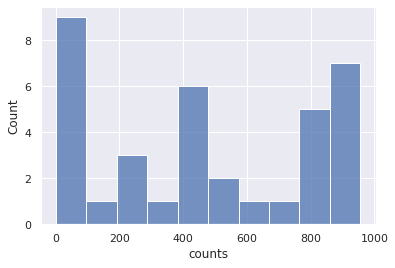

In [158]:
# Histogram of counts within FY
ax = sns.histplot(df_FY_counts['counts'], bins=10)

In [159]:
# that's not a normal distribution at ALL
# taking out FY 1981-1987 and 2013-2015

to_drop = [1981, 1982, 1983, 1984, 1985, 1986, 1987, 2013, 2014, 2015]
df_FY_counts_range = df_FY_counts.drop(df_FY_counts[df_FY_counts['FY'] < 1988].index)
df_FY_counts_range = df_FY_counts_range.drop(df_FY_counts_range[df_FY_counts_range['FY'] > 2012].index)
print(df_FY_counts_range.sort_values('FY'))

      FY  counts
24  1988     247
23  1989     269
22  1990     358
20  1991     437
21  1992     403
19  1993     469
15  1994     479
18  1995     474
14  1996     483
16  1997     476
4   1998     902
0   1999     956
3   2000     911
5   2001     893
9   2002     824
11  2003     780
1   2004     930
8   2005     834
6   2006     887
2   2007     919
7   2008     837
10  2009     797
12  2010     722
13  2011     611
17  2012     476


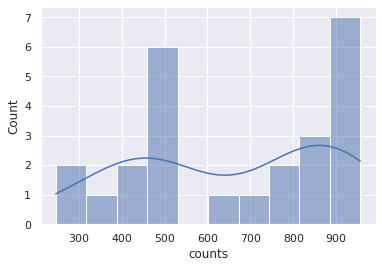

In [160]:
# Histogram of counts by FY within new-ly established range
ax = sns.histplot(df_FY_counts_range['counts'], bins = 10, kde=True)

I removed the lowest and highest number years from the data due to their abnormally low numbers. The first few years are probably low because the EPA was still establishing its regulation and data-collecting processes, and the last few years are probably lagging in data that will show up for them later.

By removing the data the graph shows more distinct spikes, but still does not seem to show a normal distribution.

## Congressional District Counts

In [161]:
df_con_dist_counts[['counts']].describe()

,counts
count,11.000000
mean,1499.727273
std,1216.403395
min,77.000000
25%,782.500000
50%,1136.000000
75%,2167.500000
max,4142.000000


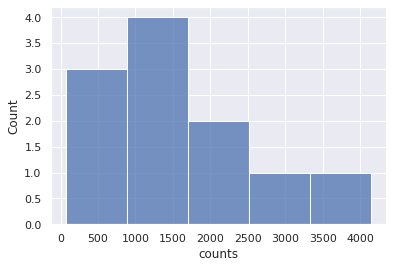

In [162]:
ax = sns.histplot(df_con_dist_counts['counts'])

# a little more normal distribution, we'll see how it works out with the FY variable

# Statistical Significance
My data is about how many Activities happened in a FY and in a particular congressional district.

Counts of Activities by Fiscal Year are not normally distributed. I think there are significant differences in this distribution that I'd like to find out about. I also want to know more about the Congressional District with the highest number of Activities and how those counts are distributed over time.

## Fiscal Year: Initial Observations

In [163]:
df_FY_counts_range.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   FY      25 non-null     int64
 1   counts  25 non-null     int64
dtypes: int64(2)
memory usage: 600.0 bytes


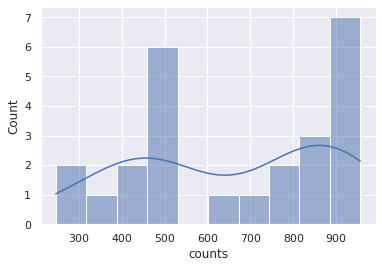

In [164]:
ax = sns.histplot(df_FY_counts_range['counts'], bins = 10, kde=True)

In [165]:
df_FY_counts_range['counts'].describe()

count     25.00000
mean     654.96000
std      234.12701
min      247.00000
25%      474.00000
50%      722.00000
75%      887.00000
max      956.00000
Name: counts, dtype: float64

In [166]:
FY_max_value = (df_FY_counts_range['counts'] == 956)
FY_counts_max = df_FY_counts_range.iloc[FY_max_value.values]
print(FY_counts_max)

FY_min_value = (df_FY_counts_range['counts'] == 247)
FY_counts_min = df_FY_counts_range.iloc[FY_min_value.values]
print(FY_counts_min)

     FY  counts
0  1999     956
      FY  counts
24  1988     247


The counts for all fiscal years showed no normal distribution, which indicated some significant differences in the data. I decided to take the years of the max number of Activities and the min number of Activities. I'll use those in the stats tests distributed by Congressional Districts below.

## Congressional Districts: Initial Observations

In [167]:
df_con_dist_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CONGRESSIONAL_DIST_NUM  11 non-null     int64
 1   counts                  11 non-null     int64
dtypes: int64(2)
memory usage: 304.0 bytes


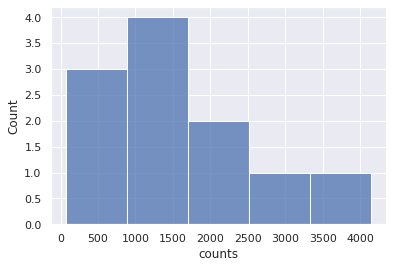

In [168]:
# Histogram of counts by Congressional District
ax = sns.histplot(df_con_dist_counts['counts'])

In [169]:
df_con_dist_counts['counts'].describe()

count      11.000000
mean     1499.727273
std      1216.403395
min        77.000000
25%       782.500000
50%      1136.000000
75%      2167.500000
max      4142.000000
Name: counts, dtype: float64

In [170]:
CD_max_value = (df_con_dist_counts['counts'] == 4142)
CD_counts_max = df_con_dist_counts.iloc[CD_max_value.values]
print(CD_counts_max)

CD_min_value = (df_con_dist_counts['counts'] == 77)
CD_counts_min = df_con_dist_counts.iloc[CD_min_value.values]
print(CD_counts_min)

   CONGRESSIONAL_DIST_NUM  counts
0                       9    4142
    CONGRESSIONAL_DIST_NUM  counts
10                       8      77


This histograms shows a normal distribution. I can test that with the kurtosis calculation. I took down the Congressional Districts with max and min total numbers of Activities for statistical testing against FY distribution below.

## Comparing FY and CD Distributions
**Null Hypothesis**: The distribution of counts by Fiscal Year is the same as the distribution of counts by Congressional District.

In [171]:
# Compare kurtosis of distribution over FY vs CD

print('The kurtosis of the FY distributions is: ', stats.kurtosis(df_FY_counts_range['counts']))
print('The kurtosis of the Congressional District distribution is: ',stats.kurtosis(df_con_dist_counts['counts']))

The kurtosis of the FY distributions is:  -1.459437268429435
The kurtosis of the Congressional District distribution is:  0.005514374589800308


In [172]:
stats.ttest_ind(df_FY_counts_range['counts'], df_con_dist_counts['counts'])

Ttest_indResult(statistic=-3.3917019038403997, pvalue=0.001776154468731675)

**Findings**:  
The distribution of Activity counts across Congressional Districts is nearly normal, with a kurtosis close to zero. The distribution across FYs, however, has a very low kurtosis and therefore a very thin tail. This implies a significant spike in the data.

With a t stat greater than the t critical value of a 2-sample t test (1.96), we can reject the null that these distributions are the same. This test is significant with p < 0.05.

## Congressional Districts: T Test
**Null Hypothesis**:  
The Congressional District with the maximum total number of Activities in the data has the same distribution of cases by FY as the district with the minimum total number of Activities.

In [173]:
print(df3.shape)
print(df3.info())

(35, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   FISCAL_YEAR  35 non-null     int64
 1   CON_DIST_1   34 non-null     Int64
 2   CON_DIST_2   34 non-null     Int64
 3   CON_DIST_3   34 non-null     Int64
 4   CON_DIST_4   34 non-null     Int64
 5   CON_DIST_5   34 non-null     Int64
 6   CON_DIST_6   34 non-null     Int64
 7   CON_DIST_7   33 non-null     Int64
 8   CON_DIST_8   20 non-null     Int64
 9   CON_DIST_9   34 non-null     Int64
 10  CON_DIST_10  32 non-null     Int64
 11  CON_DIST_11  26 non-null     Int64
dtypes: Int64(11), int64(1)
memory usage: 3.8 KB
None


In [174]:
df3.describe()

,FISCAL_YEAR,CON_DIST_1,CON_DIST_2,CON_DIST_3,CON_DIST_4,CON_DIST_5,CON_DIST_6,CON_DIST_7,CON_DIST_8,CON_DIST_9,CON_DIST_10,CON_DIST_11
count,35.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,33.000000,20.000000,34.000000,32.000000,26.000000
mean,1998.000000,33.411765,17.205882,30.205882,54.382353,73.117647,79.617647,40.303030,3.850000,121.823529,30.625000,6.846154
std,10.246951,27.444840,12.090014,18.587678,28.085384,54.871069,48.301462,28.537787,3.199918,89.578295,26.113586,6.044451
min,1981.000000,1.000000,1.000000,1.000000,3.000000,2.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000
25%,1989.500000,6.500000,5.000000,11.500000,39.750000,31.000000,48.500000,20.000000,2.000000,35.000000,9.250000,3.000000
50%,1998.000000,30.000000,18.000000,34.000000,58.000000,61.500000,83.000000,37.000000,2.500000,117.500000,20.000000,5.000000
75%,2006.500000,53.250000,23.000000,41.750000,69.000000,121.250000,115.750000,62.000000,4.250000,209.500000,50.500000,7.750000
max,2015.000000,88.000000,40.000000,73.000000,108.000000,178.000000,183.000000,89.000000,12.000000,304.000000,93.000000,24.000000


In [175]:
df3['CON_DIST_8'].describe()

count    20.000000
mean      3.850000
std       3.199918
min       1.000000
25%       2.000000
50%       2.500000
75%       4.250000
max      12.000000
Name: CON_DIST_8, dtype: float64

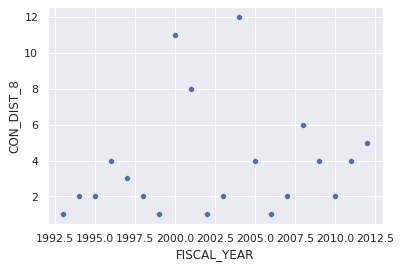

In [176]:
sns.scatterplot(x='FISCAL_YEAR', y='CON_DIST_8', data=df3)

In [177]:
df3['CON_DIST_9'].describe()

count     34.000000
mean     121.823529
std       89.578295
min        4.000000
25%       35.000000
50%      117.500000
75%      209.500000
max      304.000000
Name: CON_DIST_9, dtype: float64

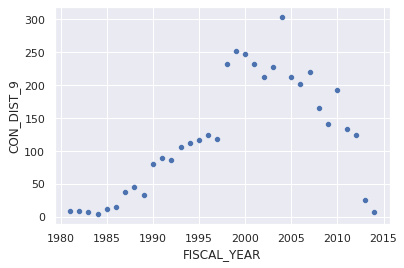

In [178]:
sns.scatterplot(x='FISCAL_YEAR', y='CON_DIST_9', data=df3)

In [179]:
# shows db with dropped nulls from fiscal year
df3_con_8_nonulls = df3[df3['CON_DIST_8'].notnull()]
df3_con_9_nonulls = df3[df3['CON_DIST_9'].notnull()]

stats.ttest_ind(df3_con_8_nonulls['CON_DIST_8'], df3_con_9_nonulls['CON_DIST_9'])

Ttest_indResult(statistic=-5.864413412459555, pvalue=3.1498343584858434e-07)

**Findings**:  
With a t statistic greater than 1.96, we reject the null hypothesis that the distributions of counts by Fiscal Year between Congressional Districts 8 and 9 are the same. This test is significant at p value < 0.05.

## Fiscal Year: T Test
**Null Hypothesis**: The distribution of counts by Congressional District between Fiscal Years 1988 and 1999 are the same.

In [180]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CONGRESSIONAL_DIST_NUM  11 non-null     object 
 1   1981                    8 non-null      float64
 2   1982                    8 non-null      float64
 3   1983                    9 non-null      float64
 4   1984                    9 non-null      float64
 5   1985                    9 non-null      float64
 6   1986                    9 non-null      float64
 7   1987                    10 non-null     float64
 8   1988                    9 non-null      float64
 9   1989                    10 non-null     float64
 10  1990                    10 non-null     float64
 11  1991                    10 non-null     float64
 12  1992                    10 non-null     float64
 13  1993                    11 non-null     int64  
 14  1994                    11 non-null     int6

In [181]:
df4['1988'].describe()

count     9.000000
mean     26.555556
std      19.894164
min       5.000000
25%       7.000000
50%      20.000000
75%      45.000000
max      54.000000
Name: 1988, dtype: float64

In [182]:
df4['1999'].describe()

count     11.000000
mean      83.545455
std       71.156677
min        1.000000
25%       43.500000
50%       67.000000
75%      117.000000
max      252.000000
Name: 1999, dtype: float64

In [183]:
df4_1988_nonulls = df4[df4['1988'].notnull()]
df4_1999_nonulls = df4[df4['1999'].notnull()]

stats.ttest_ind(df4_1988_nonulls['1988'], df4_1999_nonulls['1999'])

Ttest_indResult(statistic=-2.3192621556686293, pvalue=0.0323406122151648)

**Findings**:  
With a t statistic greater than 1.96 we have evidence to reject the null hypothesis that the distributions over Congressional Districts are the same. This test is significant at p value < 0.05.

# Conclusions
These tests are for government workers who want to analyze the way the EPA's compliance-related resources are allocated and understand trends in cases over time and across the state of Virginia.

Based in the results of this analysis, the EPA or other environmental regulation organization would know that the distribution of compliance issues over time has significant spikes that could warrant further study, but across the region the distribution is comparatively normal.

The data provides evidence that increased significantly between FY 1988 and 1999, with FY 1999 as the highest peak out of all the years. They would also see that Congressional District 9 has a significantly greater distribution of data than the district with the lowest number, District 8. This could suggest its data spikes alongside the Fiscal Year distribution.

### Results and Further Study
Congressional District 9 could require more resources in environmental regulation. That region and others like it require further study, including a trends analysis during the decade between 1988 and 1999. Adding context is essential: Future studies should include information on administration changes, new environmental compliance requirements, and significant changes in industrial and data-collecting technologies that could all account for anomalies.